In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error, mean_squared_error, mean_squared_log_error
from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from tqdm import tqdm_notebook
from itertools import product

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def mean_absolute_percentage_error(y_true,y_pred):
    """ Function to calculate MAPE"""
    return np.mean(np.abs((y_true-y_pred)/y_true)) * 100

In [3]:
data = pd.read_csv('Port Harcourt, Nigeria (4.80678 7.002953).csv', parse_dates=['created_at'] )
data.head()

,created_at,entry_id,Temperature_F,Humidity_%,PM2.5_ATM_ug/m3
0,2021-07-26 16:45:59+00:00,198,89,50,40.78
1,2021-07-26 16:48:03+00:00,199,89,50,40.09
2,2021-07-26 16:49:59+00:00,200,89,50,37.93
3,2021-07-26 16:54:03+00:00,201,89,50,33.18
4,2021-07-26 16:55:59+00:00,202,89,50,37.84


In [4]:
# Check data columns
data.columns

Index(['created_at', 'entry_id', 'Temperature_F', 'Humidity_%',
       'PM2.5_ATM_ug/m3'],
      dtype='object')

In [5]:

drop_cols = ['entry_id', 'Temperature_F', 'Humidity_%']
data.drop(drop_cols, axis=1, inplace=True)
data.rename(columns={'PM2.5_ATM_ug/m3': 'PM'},inplace=True, errors='raise')
data.head()

,created_at,PM
0,2021-07-26 16:45:59+00:00,40.78
1,2021-07-26 16:48:03+00:00,40.09
2,2021-07-26 16:49:59+00:00,37.93
3,2021-07-26 16:54:03+00:00,33.18
4,2021-07-26 16:55:59+00:00,37.84


In [6]:
# check for missing data
data.isnull().sum()

created_at    0
PM            0
dtype: int64

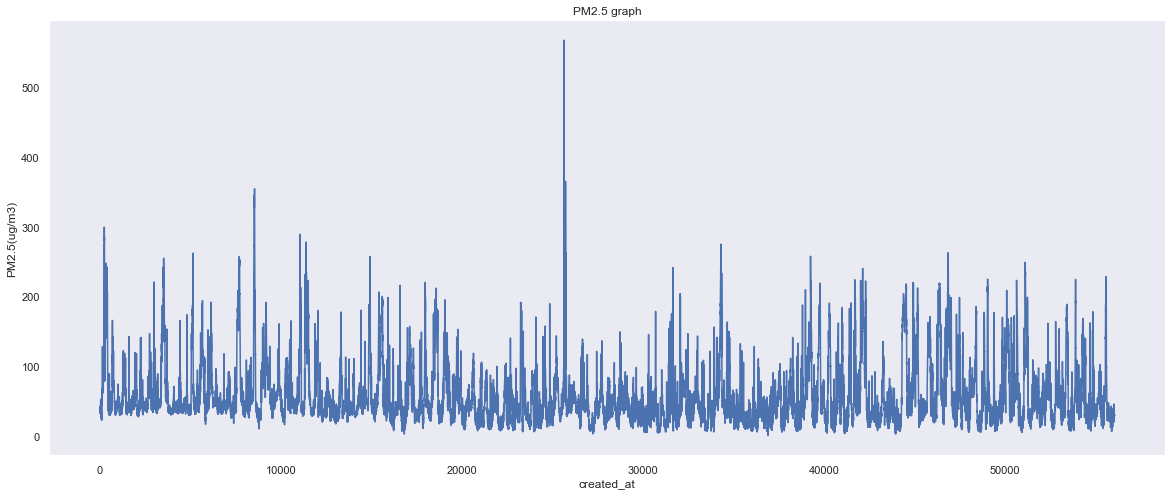

In [7]:
# Plot the time series
plt.figure(figsize=(20, 8))
plt.plot(data['PM'])
plt.title('PM2.5 graph')
plt.ylabel('PM2.5(ug/m3)')
plt.xlabel('created_at')
plt.grid(False)
plt.show()

Not much can be seen on this graph above in terms of seasonality or if it's stationary. Might do a data slice to view or better still do a groupby the maximum data or average in a day.

In [8]:
df_sampled = data.resample('D', on='created_at').PM.mean().reset_index()
#df_sampled.to_frame(name='PM')
df = df_sampled.set_index(['created_at'])
df.head()

,PM
created_at,
2021-07-26 00:00:00+00:00,55.164698
2021-07-27 00:00:00+00:00,97.020537
2021-07-28 00:00:00+00:00,54.527722
2021-07-29 00:00:00+00:00,45.996642
2021-07-30 00:00:00+00:00,53.224902


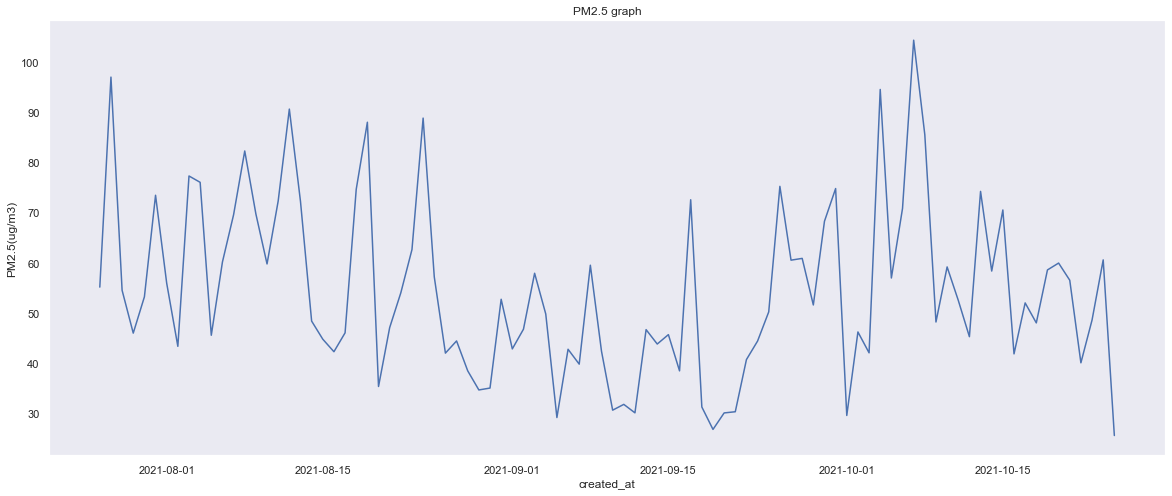

In [9]:
plt.figure(figsize=(20, 8))
plt.plot(df['PM'])
plt.title('PM2.5 graph')
plt.ylabel('PM2.5(ug/m3)')
plt.xlabel('created_at')
plt.grid(False)
plt.show()

This looks better than the previous graph, There seems to be some seasonality but not sure about stationary. We can check if its stationary with the Dicker Fuller test.

## Moving Average

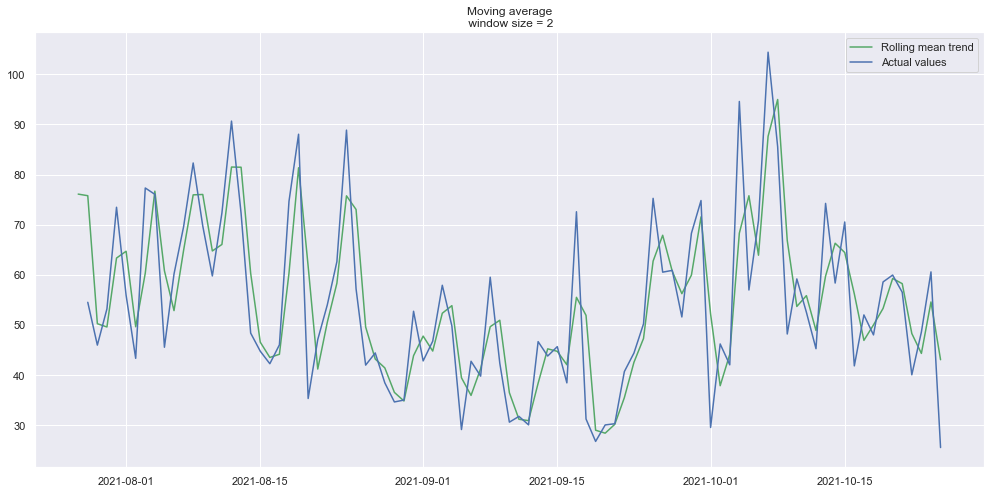

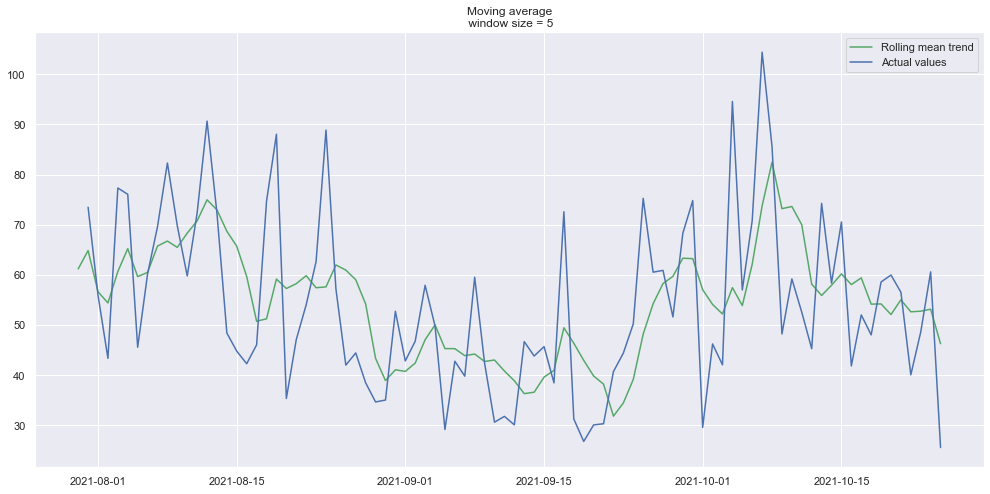

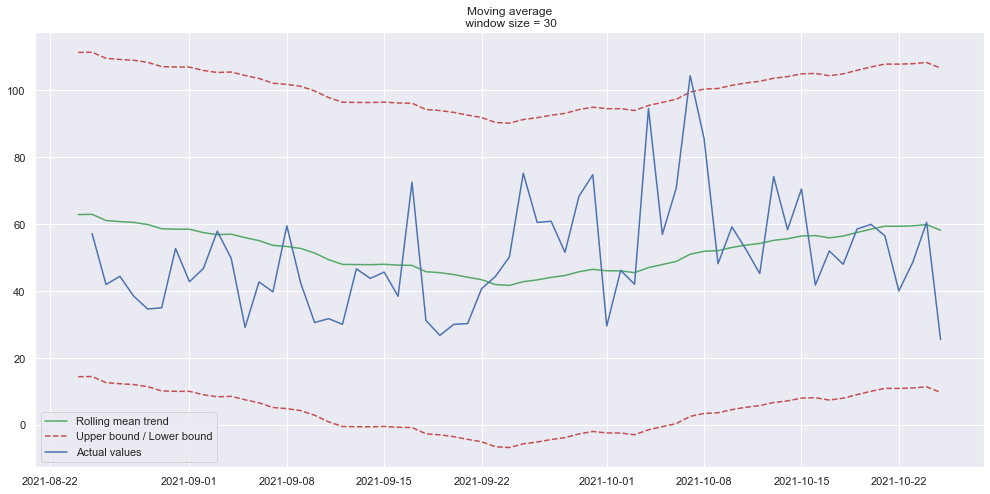

In [23]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)
    
#Smooth by the previous 2 days
plot_moving_average(df.PM, 2)

#Smooth by the previous week (7 days)
plot_moving_average(df.PM, 5)

#Smooth by previous month (30 days)
plot_moving_average(df.PM, 30, plot_intervals=True)

The MA graphs shows a downward trend at the end.This might mean that the PM2.5 values will likely go down in the following days.

## Exponential Smoothing

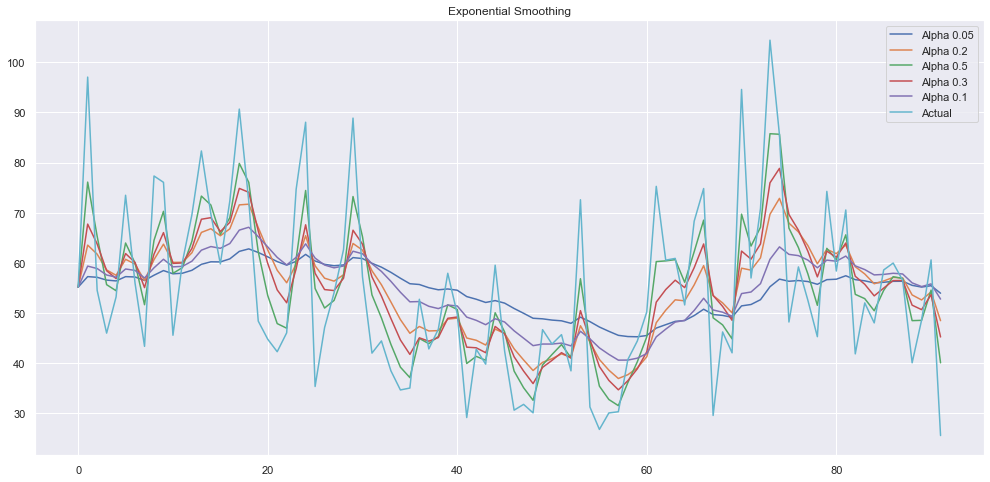

In [11]:
def exponential_smoothing(series, alpha):

    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result
  
def plot_exponential_smoothing(series, alphas):
 
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);

plot_exponential_smoothing(df.PM, [0.05, 0.2,0.5,0.3, 0.1])

An alpha value of 0.5 smoothed the curve while picking up most of the upward and downward trends.

## Double Exponential Smoothing

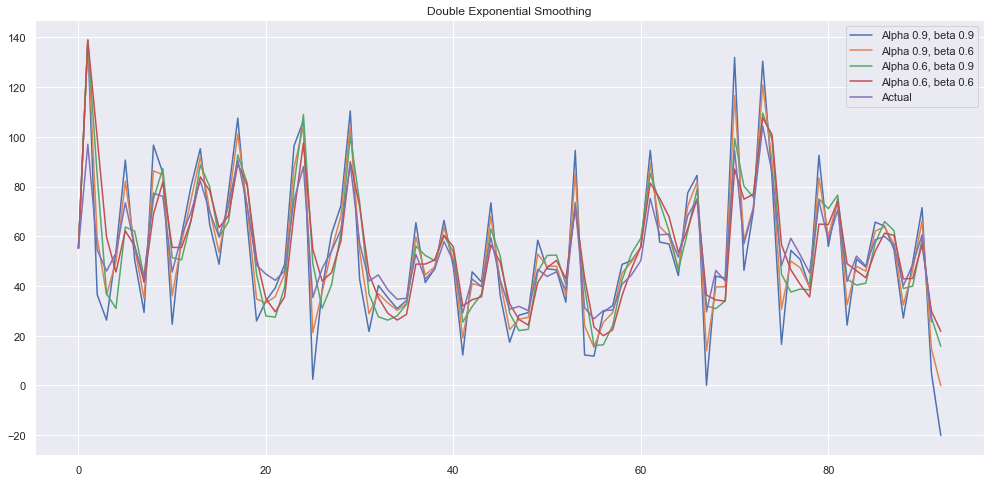

In [12]:
def double_exponential_smoothing(series, alpha, beta):

    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

def plot_double_exponential_smoothing(series, alphas, betas):
     
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)
    
plot_double_exponential_smoothing(df.PM, alphas=[0.9, 0.6], betas=[0.9, 0.6])

The double smoothing works perfectly for the data, especially alpha  = 0.9, beta = 0.9

## Modelling

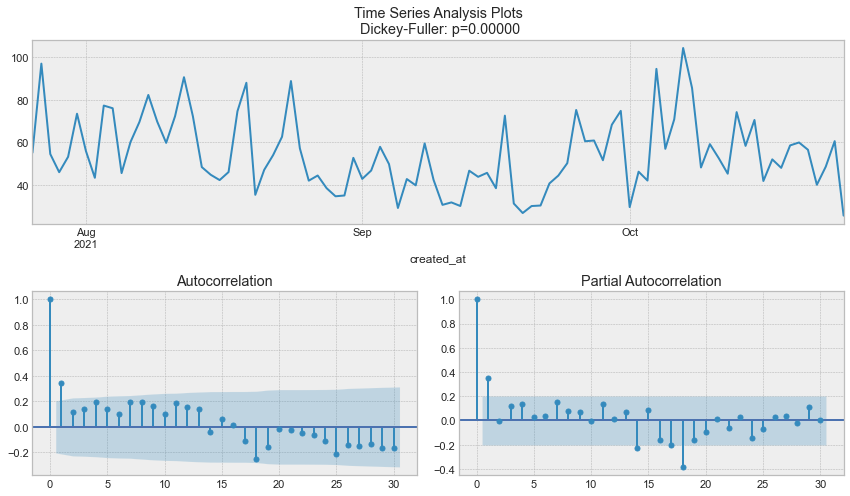

In [13]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(df.PM, lags=30)

From the chart above, the Dicker Fuller test gives a result that p=0, which indicates that the data is stationary. We can also see seasonality though not too consistent in the data.

## SARIMA

In [14]:

#Set initial values and some bounds
ps = range(0, 5)
d = 1
qs = range(0, 5)
Ps = range(0, 5)
D = 1
Qs = range(0, 5)
s = 5

#Create a list with all possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Train many SARIMA models to find the best set of parameters
def optimize_SARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
    """
    
    results = []
    best_aic = float('inf')
    
    for param in tqdm_notebook(parameters_list):
        try: model = sm.tsa.statespace.SARIMAX(df.PM, order=(param[0], d, param[1]),
                                               seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        
        #Save best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
        
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    #Sort in ascending order, lower AIC is better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

result_table = optimize_SARIMA(parameters_list, d, D, s)

#Set parameters that give the lowest AIC (Akaike Information Criteria)
p, q, P, Q = result_table.parameters[0]

best_model = sm.tsa.statespace.SARIMAX(df.PM, order=(p, d, q),
                                       seasonal_order=(P, D, Q, s)).fit(disp=-1)

print(best_model.summary())


                                 Statespace Model Results                                
Dep. Variable:                                PM   No. Observations:                   92
Model:             SARIMAX(3, 1, 3)x(0, 1, 1, 5)   Log Likelihood                -365.252
Date:                           Wed, 10 Nov 2021   AIC                            746.504
Time:                                   11:06:34   BIC                            766.138
Sample:                               07-26-2021   HQIC                           754.406
                                    - 10-25-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2956      0.109      2.708      0.007       0.082       0.509
ar.L2          0.6402      0.153      4.17

2021-10-26 00:00:00+00:00    30.167072
2021-10-27 00:00:00+00:00    42.842895
2021-10-28 00:00:00+00:00    46.870405
Freq: D, dtype: float64
26.89635550007732


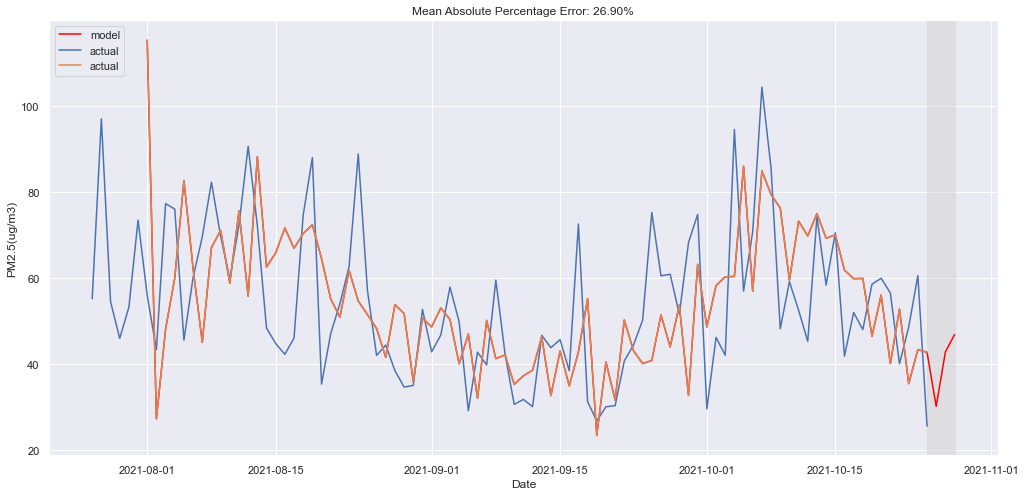

In [58]:
def plot_SARIMA(series, model, n_steps):
    """
        Plot model vs predicted values
        
        series - dataset with time series
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
    """
    
    data = series.copy().rename(columns = {'PM': 'actual'})
    #print(data)
    data['arima_model'] = model.fittedvalues
    #Make a shift on s+d steps, because these values were unobserved by the model due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    #Forecast on n_steps forward
    forecast = model.predict(start=data.shape[0], end=data.shape[0] + n_steps)
    forecast = data.arima_model.append(forecast)
    # forecast_shift = forecast[::5]
    # print(forecast_shift)
    #Calculate error
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])
    
    plt.figure(figsize=(17, 8))
    plt.title('Mean Absolute Percentage Error: {0:.2f}%'.format(error))
    plt.ylabel('PM2.5(ug/m3)')
    plt.xlabel('Date')
    plt.plot(forecast, color='red', label='model')
    plt.axvspan(data.index[-1], forecast.index[-1],alpha=0.5, color='lightgrey')
    plt.plot(data, label='actual')
    plt.legend()
    plt.grid(True);
    
plot_SARIMA(df, best_model, 2)
print(best_model.predict(start=df.PM.shape[0], end=df.PM.shape[0] + 2))
print(mean_absolute_percentage_error(df.PM[s+d:], best_model.fittedvalues[s+d:]))